In [21]:
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from os import listdir
from os.path import isfile, join

In [233]:
# На вот таких параметрах хорошо работает
# circles = cv2.HoughCircles(new_image, cv2.HOUGH_GRADIENT, 1, 15,
#                                param1=100, param2=15,
#                                minRadius=24, maxRadius=35)

In [43]:
default_penalty=1.

In [44]:
import pytesseract as pts
pts.pytesseract.tesseract_cmd = r"/usr/local/bin/tesseract"

def prepare_image(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    # Цвет КП ММБ
    new_image = ((img[:,:,0] == 255) & (img[:,:,1] == 34) & (img[:,:,2] == 141) )*255
    new_image = new_image.astype(np.uint8)
    return new_image

def parse(new_image,circles):
    rows = []
    for i,circle in enumerate(circles[0]):
        x = int(circle[0])
        y = int(circle[1])
        radius = circle[2]

        delta = 140
        y1 = max(y-delta,0)
        y2 = min(y+delta,new_image.shape[0])
        x1 = max(x-delta,0)
        x2 = min(x+delta,new_image.shape[1])
        temp_img = new_image[y1:y2,x1:x2]
        temp_img = 255 - temp_img

        new_center_y = y-y1
        new_center_x = x-x1

        delta_r = 5
        max_r = 130

        x_coord = x
        y_coord = y
        #print (temp_img.shape,x_coord,y_coord,x1,x2,new_image.shape,y1,y2)

        for x in range(temp_img.shape[0]):
            for y in range(temp_img.shape[1]):
                dist = np.sqrt(pow((x-new_center_y),2) + pow((y-new_center_x),2))
                if (dist<radius+delta_r) and (dist>radius-delta_r): #это круг, убираем
                    temp_img[x,y]=255
                if (dist>max_r):
                    temp_img[x,y]=255
                            
        result = pts.image_to_string(temp_img,config='--psm 10 -c tessedit_char_whitelist=0123456789')

        result_digits = ''.join(filter(lambda x: x in '1234567890',result))

        cv2.imwrite('results/%d(%s).png'%(i,result_digits),temp_img)

        rows.append([x_coord,y_coord,radius,result,result_digits])
    result = pd.DataFrame(rows,columns = ['x','y','radius','text','text_digits'])
    return result


def find_kp(filename):
    img = prepare_image(filename)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15,
                               param1=100, param2=15,
                               minRadius=24, maxRadius=35)
    df = parse(img,circles)
    df['penalty'] = default_penalty
    return df,circles

In [45]:
def plot_circles_on_img(filename,circles):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if circles is not None:
        
        print (circles.shape)
        for _,row in circles.iterrows():
            center = (row.x, row.y)
            # circle center
            cv2.circle(img, center, 1, (0, 255, 0), 3)
            # circle outline
            radius = int(row.radius)
            cv2.circle(img, center, radius, (0, 255, 0), 3)
            
            #print KP num
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = center
            fontScale              = 1
            fontColor              = (0,0,0)
            lineType               = 3

            cv2.putText(img,row.text_digits, 
                bottomLeftCornerOfText, 
                font, 
                fontScale,
                fontColor,
                lineType
                       )
    return img

In [6]:
!ls maps

2019o            mmb2016o-l1.png  mmb2017o-l2.png  mmb2018v-l1a.png
2019v            mmb2017o-l1a.png mmb2018v-l1.png  mmb2018v-l2.png


In [46]:
path = 'maps/2019o'
onlyfiles = [join(path,f) for f in listdir(path) if (isfile(join(path, f)) and f[-4:] != '.dat')]
onlyfiles.sort()

In [47]:
onlyfiles

['maps/2019o/1v.png', 'maps/2019o/2v.png', 'maps/2019o/3v.png']

In [71]:
#map_file = 'maps/mmb2016o-l1.png'
data = []
for filename in onlyfiles:
    print (filename)
    points,circles = find_kp(filename)
    data.append([filename,points,circles])
    points.to_csv(filename+'.dat',index=False)

maps/2019o/1v.png
maps/2019o/2v.png
maps/2019o/3v.png


## Проверим что все КП определились визуально

In [26]:
map_id = 1

In [74]:
d = pd.read_csv('maps/2019o/1v.png.dat',dtype={'text_digits':'str'})

In [75]:
d

,x,y,radius,text,text_digits,penalty
0,488,2254,28.200001,4.0,4,1.0
1,1410,1856,28.200001,6.0,6,1.0
2,2013,1991,28.200001,7.0,7,1.0
3,2489,1431,28.200001,14.0,14,1.0
4,2675,454,28.200001,20.0,20,1.0
5,2972,383,28.200001,22.0,22,1.0
6,2022,1585,30.500000,9.0,9,1.0
7,2120,513,30.500000,16.0,164,1.0
8,2392,1777,30.500000,10.0,10,1.0
9,2496,867,30.500000,17.0,17,1.0


In [49]:
data[map_id][1].sort_values('text_digits')

,x,y,radius,text,text_digits,penalty
4,1580,1239,28.200001,2,2,1.0
7,1314,2484,30.200001,23,23,1.0
3,1498,1595,28.200001,24,24,1.0
1,845,1494,28.200001,25,25,1.0
6,1177,1343,30.200001,26,26,1.0
5,1638,780,30.500000,31,31,1.0
0,774,242,28.200001,32,32,1.0
2,1339,444,28.200001,33,33,1.0
8,1500,21,27.400000,34,34,1.0


In [41]:
x = 1590
y=1239
get_neares_point(x,y)

(x              1580
 y              1239
 radius         28.2
 text              2
 text_digits       2
 Name: 4, dtype: object, 10.0)

In [40]:
def get_neares_point(x,y):
    dat = data[map_id][1]
    dist = dat.apply(lambda row: ((row.x-x)**2+(row.y-y)**2)**0.5,axis=1)
    argmin = dist.values.argmin()
    min_row = dat.iloc[argmin]
    return min_row,dist[argmin]

In [12]:
data[map_id][2]

array([[[ 774.5,  242.5,   28.2],
        [ 845.5, 1494.5,   28.2],
        [1339.5,  444.5,   28.2],
        [1498.5, 1595.5,   28.2],
        [1580.5, 1239.5,   28.2],
        [1638.5,  780.5,   30.5],
        [1177.5, 1343.5,   30.2],
        [1314.5, 2484.5,   30.2],
        [1500.5,   21.5,   27.4]]], dtype=float32)

In [13]:
def on_mouse_move(event):
    print('Event received:',event.x,event.y)

(9, 5)


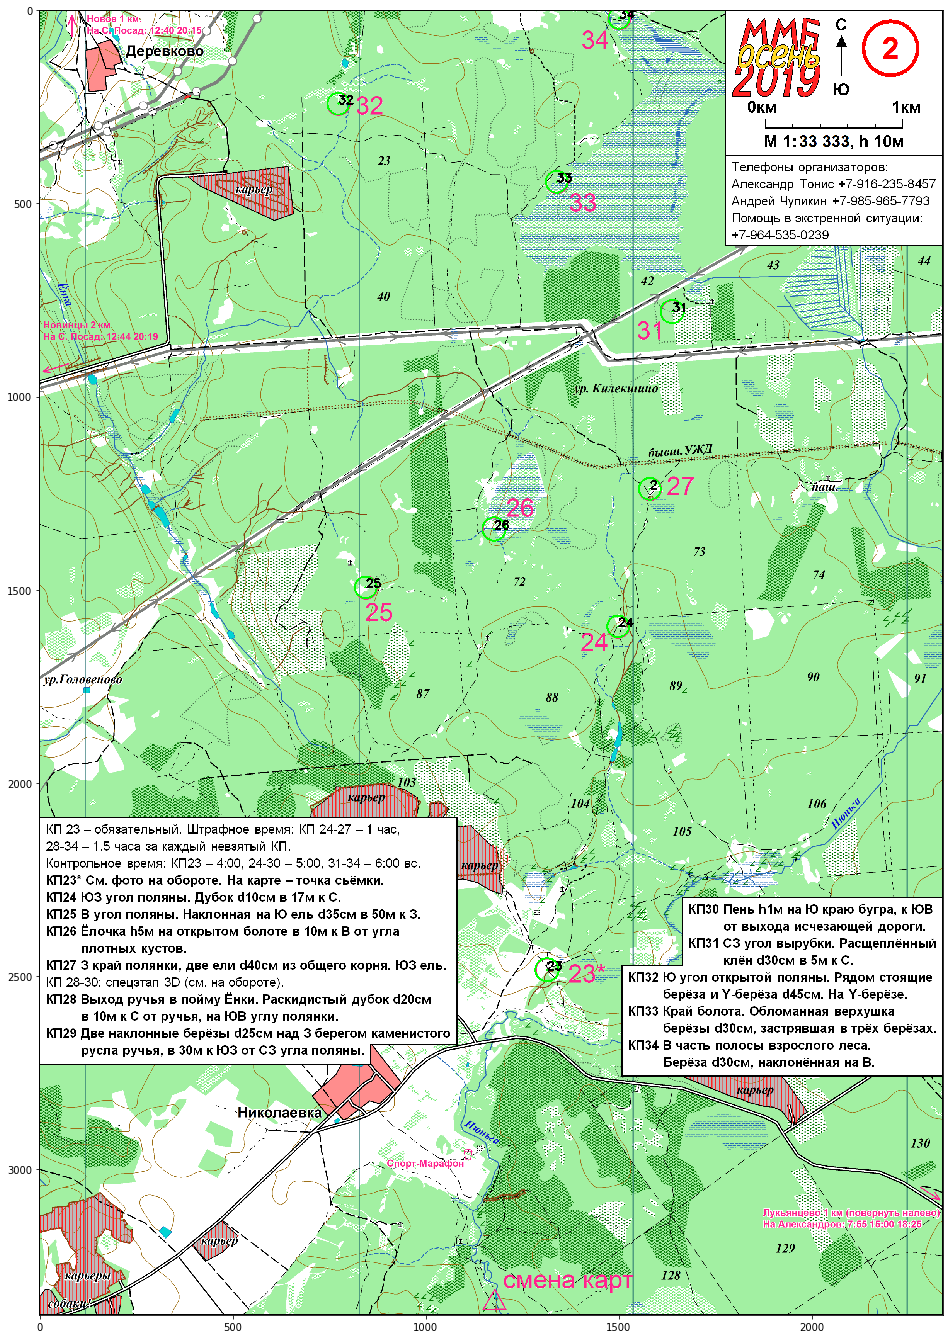

In [22]:
img_test = data[map_id][0]

img_for_plot = plot_circles_on_img(img_test,data[map_id][1])

plt.figure(figsize=(24,24))
plt.imshow(img_for_plot,cmap='gray')
plt.show()



<IPython.core.display.Javascript object>


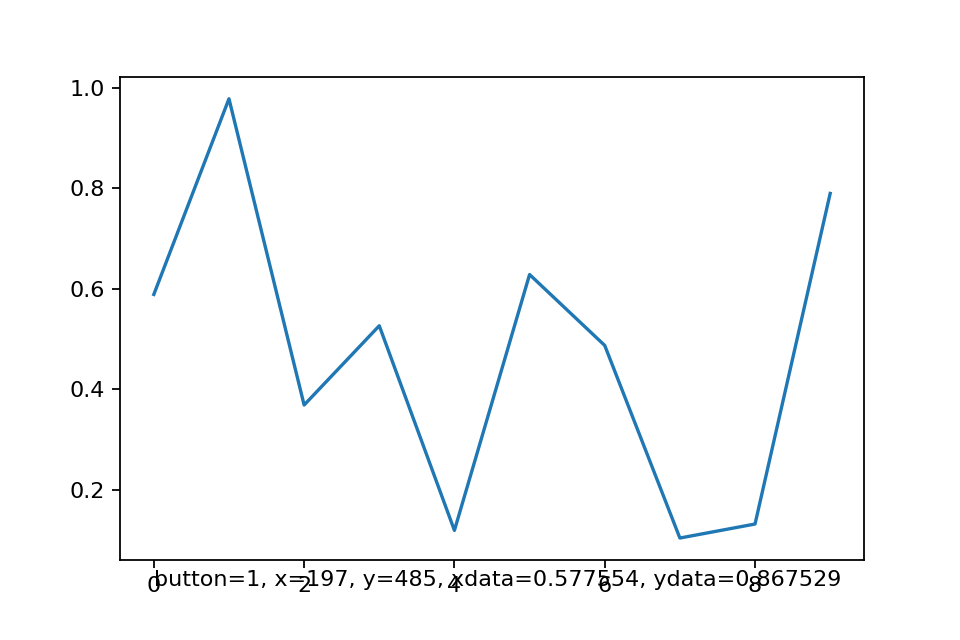

In [19]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)